<a href="https://colab.research.google.com/github/ANadineS/IntDeepLearning/blob/main/Final_A2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell, Dropout
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

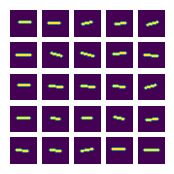

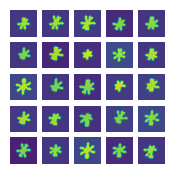

In [4]:
from scipy.ndimage import rotate
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='*'))

In [5]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

11490434/11490434 [==============================] - 0s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #5485

X_text: "27-42" = y_text: "-15"


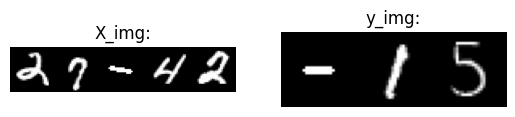

Query #5230

X_text: "26+15" = y_text: "41 "


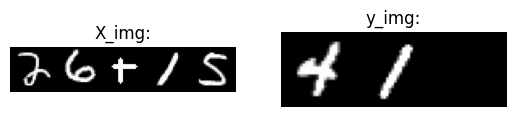

Query #6211

X_text: "31-5 " = y_text: "26 "


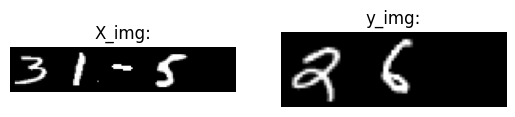

Query #5022

X_text: "25+11" = y_text: "36 "


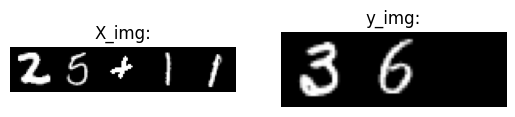

Query #3162

X_text: "15+81" = y_text: "96 "


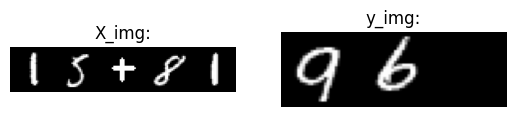

Query #1184

X_text: "5+92 " = y_text: "97 "


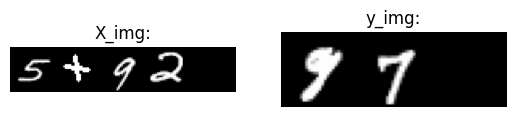

Query #7356

X_text: "36+78" = y_text: "114"


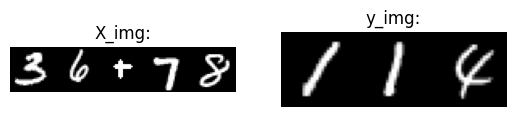

Query #4847

X_text: "24-23" = y_text: "1  "


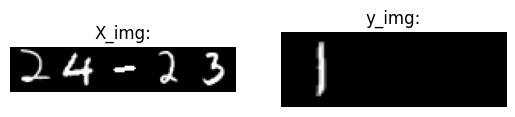

Query #6538

X_text: "32+69" = y_text: "101"


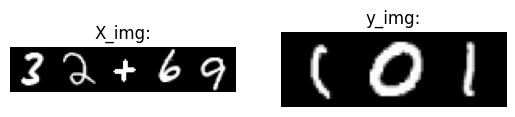

Query #7160

X_text: "35+80" = y_text: "115"


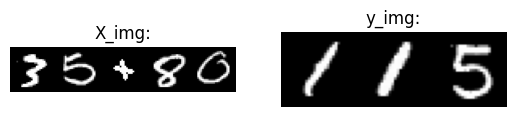

In [6]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [7]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [8]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [9]:
split_ratios = [0.95, 0.9, 0.75, 0.6, 0.5]  # Adjust these ratios as needed

for split_ratio in split_ratios:
    # Split the Data
    X_text_train, X_text_test, X_img_train, X_img_test, y_text_train, y_text_test, y_img_train, y_img_test = train_test_split(
        X_text, X_img, y_text, y_img, test_size=1 - split_ratio, random_state=42
    )

    # Encode the training and test sets
    X_text_train_onehot = encode_labels(X_text_train)
    y_text_train_onehot = encode_labels(y_text_train)

    X_text_test_onehot = encode_labels(X_text_test)
    y_text_test_onehot = encode_labels(y_text_test)

    # Train the Model
    model = build_text2text_model()
    model.fit(X_text_train_onehot, y_text_train_onehot, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the Model
    test_loss, test_accuracy = model.evaluate(X_text_test_onehot, y_text_test_onehot, verbose=0)

    # Print or store the results
    print(f"Test Accuracy for {split_ratio * 100}% training data: {test_accuracy}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed (TimeDist  (None, 3, 13)             3341      
 ributed)                                                        
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Test Accuracy for 95

In [10]:
# Final model
X_text_train, X_text_test, X_img_train, X_img_test, y_text_train, y_text_test, y_img_train, y_img_test = train_test_split(
    X_text, X_img, y_text, y_img, test_size=0.05, random_state=42
)

# Encode the training and test sets
X_text_train_onehot = encode_labels(X_text_train)
y_text_train_onehot = encode_labels(y_text_train)

X_text_test_onehot = encode_labels(X_text_test)
y_text_test_onehot = encode_labels(y_text_test)

# Train the Model
model = build_text2text_model()
model.fit(X_text_train_onehot, y_text_train_onehot, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_text_test_onehot, y_text_test_onehot, verbose=0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_5 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_5 (TimeDi  (None, 3, 13)             3341      
 stributed)                                                      
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Print or store the results
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions_onehot = model.predict(X_text_test_onehot)

# Convert one-hot encoded predictions and actual values to text
predictions_text = [decode_labels(pred) for pred in predictions_onehot]

# Find indices where predictions differ from actual values
incorrect_indices = np.where(predictions_text != y_text_test)[0]

# Display the queries and solutions for incorrectly predicted samples
for idx in incorrect_indices[0:15]:
    print("Query:")
    print(X_text_test[idx])
    print("Actual Solution:")
    print(y_text_test[idx])
    print("Predicted Solution:")
    print(predictions_text[idx])
    print("\n")

Test Accuracy: 0.9596666693687439
32/32 [==============================] - 1s 3ms/step
Query:
15+1 
Actual Solution:
16 
Predicted Solution:
15 


Query:
98-85
Actual Solution:
13 
Predicted Solution:
12 


Query:
81+48
Actual Solution:
129
Predicted Solution:
128


Query:
96-96
Actual Solution:
0  
Predicted Solution:
-1 


Query:
37-29
Actual Solution:
8  
Predicted Solution:
9  


Query:
87-3 
Actual Solution:
84 
Predicted Solution:
85 


Query:
52+3 
Actual Solution:
55 
Predicted Solution:
54 


Query:
4-85 
Actual Solution:
-81
Predicted Solution:
-91


Query:
65-68
Actual Solution:
-3 
Predicted Solution:
-4 


Query:
67-9 
Actual Solution:
58 
Predicted Solution:
57 


Query:
73-76
Actual Solution:
-3 
Predicted Solution:
-4 


Query:
7-9  
Actual Solution:
-2 
Predicted Solution:
-1 


Query:
76+52
Actual Solution:
128
Predicted Solution:
127


Query:
55-6 
Actual Solution:
49 
Predicted Solution:
59 


Query:
83-7 
Actual Solution:
76 
Predicted Solution:
77 





---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [16]:
def build_image2text_model(lstm_units, dropout_rate, conv_filters):
    image2text = Sequential()

    # Encoder (for image sequences)
    image2text.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 28, 28, 1)))
    image2text.add(TimeDistributed(Flatten()))
    image2text.add(LSTM(lstm_units))
    image2text.add(Dropout(dropout_rate))

    # Repeat the output for max_answer_length times
    image2text.add(RepeatVector(max_answer_length))

    # Decoder (for generating text)
    image2text.add(LSTM(lstm_units, return_sequences=True))
    image2text.add(Dropout(dropout_rate))
    image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Compile the model
    image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    image2text.summary()

    return image2text

param_grid = {
    'lstm_units': [256, 512],
    'dropout_rate': [0.3, 0.5, 0.8],
    'conv_filters': [16, 32, 64]
}


In [ ]:
from itertools import product
import pandas as pd
results = []

for params in product(*param_grid.values()):
  lstm_units, dropout_rate, conv_filters = params
  print(f"Training model with LSTM units: {lstm_units}, Dropout rate: {dropout_rate}, Convolutional filters: {conv_filters}")

  # Encode the training and test sets
  y_text_train_onehot = encode_labels(y_text_train)
  y_text_test_onehot = encode_labels(y_text_test)

  # Build and train the image-to-text model
  image2text_model = build_image2text_model(lstm_units, dropout_rate, conv_filters)
  image2text_model.fit(X_img_train, y_text_train_onehot, epochs=20, batch_size=32, validation_split=0.2)

  # Evaluate the model
  test_loss_img, test_accuracy_img = image2text_model.evaluate(X_img_test, y_text_test_onehot)
  print(f'Image-to-Text Model Test Accuracy: {test_accuracy_img}')

  results.append((lstm_units, dropout_rate, conv_filters, test_accuracy))

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['LSTM Units', 'Dropout Rate', 'Conv Filters', 'Test Accuracy'])

# Display the DataFrame
print("Results Overview:")
print(results_df)

Training model with LSTM units: 256, Dropout rate: 0.3, Convolutional filters: 16
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, None, 26, 26, 32   320       
 stributed)                  )                                   
                                                                 
 time_distributed_7 (TimeDi  (None, None, 21632)       0         
 stributed)                                                      
                                                                 
 lstm_12 (LSTM)              (None, 256)               22414336  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 repeat_vector_6 (RepeatVec  (None, 3, 256)            0         
 tor)                                 

In [ ]:
from keras.layers import BatchNormalization
from keras.regularizers import l2

def build_image2text_model(lstm_units, dropout_rate, conv_filters):
    image2text = Sequential()

    # Encoder (for image sequences)
    image2text.add(TimeDistributed(Conv2D(32, (7, 7), activation='relu'), input_shape=(None, 28, 28, 1)))
    image2text.add(TimeDistributed(Flatten()))
    image2text.add(LSTM(lstm_units))
    #image2text.add(LSTM(lstm_units, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001)))
    image2text.add(Dropout(dropout_rate))

    # Repeat the output for max_answer_length times
    image2text.add(RepeatVector(max_answer_length))

    # Decoder (for generating text)
    image2text.add(LSTM(lstm_units, return_sequences=True))
    #image2text.add(LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001)))
    image2text.add(Dropout(dropout_rate))
    image2text.add(TimeDistributed(Dense(128, activation='relu')))
    #image2text.add(TimeDistributed(Dense(128, activation='relu', kernel_regularizer=l2(0.0001))))
    image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Compile the model
    image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    image2text.summary()

    return image2text

param_grid = {
    'lstm_units': [1024],
    'dropout_rate': [0.5],
    'conv_filters': [16]
}


In [ ]:
from itertools import product
import pandas as pd
results = []

for params in product(*param_grid.values()):
    lstm_units, dropout_rate, conv_filters = params
    print(f"Training model with LSTM units: {lstm_units}, Dropout rate: {dropout_rate}, Convolutional filters: {conv_filters}")

    # Encode the training and test sets
    y_text_train_onehot = encode_labels(y_text_train)
    y_text_test_onehot = encode_labels(y_text_test)

    # Build and train the image-to-text model
    image2text_model = build_image2text_model(lstm_units, dropout_rate, conv_filters)
    image2text_model.fit(X_img_train, y_text_train_onehot, epochs=20, batch_size=32, validation_split=0.05)

    # Evaluate the model
    test_loss_img, test_accuracy_img = image2text_model.evaluate(X_img_test, y_text_test_onehot)
    print(f'Image-to-Text Model Test Accuracy: {test_accuracy_img:.2f}%')  # Formatted to display as a percentage

    # Append the results in text format
    results.append((lstm_units, dropout_rate, conv_filters, f"{test_accuracy_img:.2f}%"))

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['LSTM Units', 'Dropout Rate', 'Conv Filters', 'Test Accuracy'])

# Display the DataFrame in text format
print("Results Overview:")
print(results_df.to_string(index=False))  # Using to_string for text format output


Training model with LSTM units: 1024, Dropout rate: 0.5, Convolutional filters: 16
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_75 (TimeD  (None, None, 22, 22, 32   1600      
 istributed)                 )                                   
                                                                 
 time_distributed_76 (TimeD  (None, None, 15488)       0         
 istributed)                                                     
                                                                 
 lstm_57 (LSTM)              (None, 1024)              67637248  
                                                                 
 dropout_26 (Dropout)        (None, 1024)              0         
                                                                 
 repeat_vector_27 (RepeatVe  (None, 5, 1024)           0         
 ctor)                              

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
# Create the text-to-image model
text2image = Sequential()

# Encoder (for text sequences)
text2image.add(LSTM(256, input_shape=(None, len(unique_characters))))

# Repeat the output for max_answer_length times
text2image.add(RepeatVector(max_answer_length))

# Decoder (for generating images)
text2image.add(LSTM(256, return_sequences=True))
text2image.add(TimeDistributed(Dense(128, activation='relu')))  # Adjust the units according to your needs
text2image.add(TimeDistributed(Dense(28 * 28, activation='sigmoid')))  # Output layer with 28*28 units for each pixel
text2image.add(Reshape((max_answer_length, 28, 28, 1)))  # Reshape to match the image dimensions

# Compile the model
text2image.compile(loss='mse', optimizer='adam', metrics=['accuracy']) # gives 86% accuracy
#text2image.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # gives 60-ish% accuracy

text2image.summary()

In [ ]:
text2image.fit(X_text_train_onehot, y_img_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
test_loss, test_accuracy = text2image.evaluate(X_text_test_onehot, y_img_test, verbose=0)
print(f"Text to Image Test accuracy: {test_accuracy}")

Text to Image Test accuracy: 0.8611850142478943


First 5 text queries: ['53+25' '10-20' '43+34' '5+57 ' '69+51']
First 5 Answers: ['78 ' '-10' '77 ' '62 ' '120']
1/1 [==============================] - 1s 629ms/step
Generated Image 0


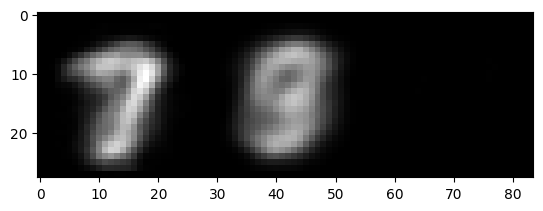

Generated Image 1


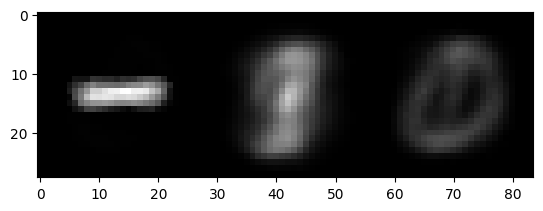

Generated Image 2


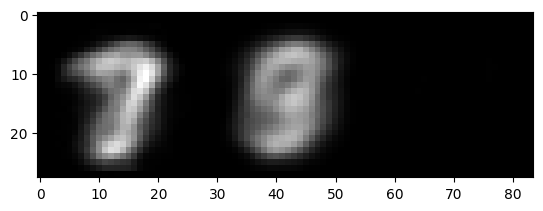

Generated Image 3


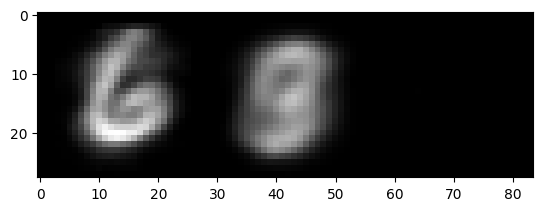

Generated Image 4


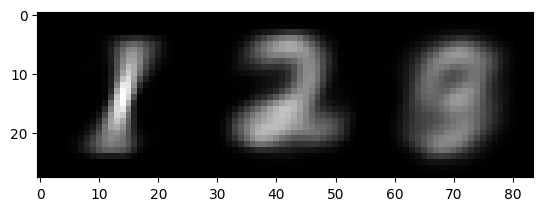

In [ ]:
#Shows the first 5 queries of the test dataset and the corresponding generated images
print(f"First 5 text queries: {X_text_test[0:5]}")
print(f"First 5 Answers: {y_text_test[0:5]}")
generated_images = text2image.predict(X_text_test_onehot[0:5])

for i in range(5):
  print(f"Generated Image {i}")
  plt.imshow(np.hstack(generated_images[i]), cmap='gray')
  plt.show()

In [ ]:
#Added LSTM layer (mainly units can be tuned, as well as number of LSTM layers in encoder)
text2image = Sequential()

# Encoder (for text sequences)
text2image.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))  # Set return_sequences to True
text2image.add(LSTM(256))

# Repeat the output for max_answer_length times
text2image.add(RepeatVector(max_answer_length))

# Decoder (for generating images)
text2image.add(LSTM(256, return_sequences=True))
text2image.add(TimeDistributed(Dense(128, activation='relu')))
text2image.add(TimeDistributed(Dense(28 * 28, activation='sigmoid')))
text2image.add(Reshape((max_answer_length, 28, 28, 1)))

text2image.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#text2image.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

text2image.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, None, 256)         276480    
                                                                 
 lstm_17 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_8 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_18 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_11 (TimeD  (None, 3, 128)            32896     
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, 3, 784)           

In [ ]:
text2image.fit(X_text_train_onehot, y_img_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
test_loss, test_accuracy = text2image.evaluate(X_text_test_onehot, y_img_test, verbose=0)
print(f"Text to Image Test accuracy (additional LSTM layer in encoding): {test_accuracy}")

Text to Image Test accuracy (additional LSTM layer in encoding): 0.8624046444892883


First 5 text queries: ['53+25' '10-20' '43+34' '5+57 ' '69+51']
First 5 Answers: ['78 ' '-10' '77 ' '62 ' '120']
1/1 [==============================] - 1s 929ms/step
Generated Image 0


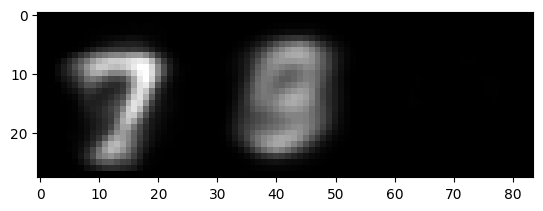

Generated Image 1


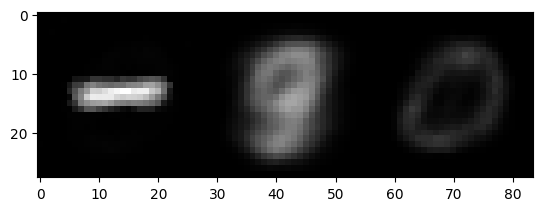

Generated Image 2


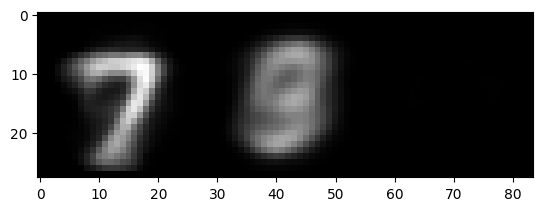

Generated Image 3


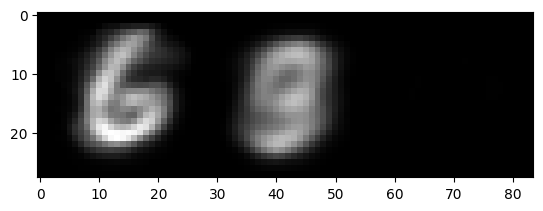

Generated Image 4


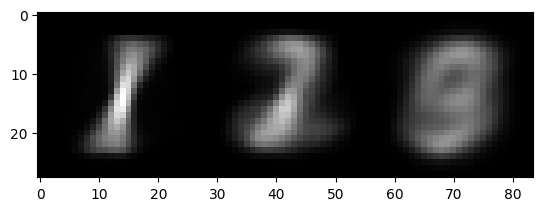

In [ ]:
#Shows the first 5 queries of the test dataset and the corresponding generated images
print(f"First 5 text queries: {X_text_test[0:5]}")
print(f"First 5 Answers: {y_text_test[0:5]}")

generated_images = text2image.predict(X_text_test_onehot[0:5])

for i in range(5):
  print(f"Generated Image {i}")
  plt.imshow(np.hstack(generated_images[i]), cmap='gray')
  plt.show()

In [ ]:
#more Added LSTM layers (mainly units can be tuned, as well as number of LSTM layers in encoder)
text2image = Sequential()

# Encoder (for text sequences)
text2image.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))  # Set return_sequences to True

# Add additional LSTM layers
text2image.add(LSTM(256, return_sequences=True))
text2image.add(LSTM(256, return_sequences=True))  # You can adjust the number of units
text2image.add(LSTM(256))

# Repeat the output for max_answer_length times
text2image.add(RepeatVector(max_answer_length))

# Decoder (for generating images)
text2image.add(LSTM(256, return_sequences=True))
text2image.add(TimeDistributed(Dense(128, activation='relu')))
text2image.add(TimeDistributed(Dense(28 * 28, activation='sigmoid')))
text2image.add(Reshape((max_answer_length, 28, 28, 1)))

text2image.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#text2image.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

text2image.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, None, 256)         276480    
                                                                 
 lstm_20 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_21 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_22 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_9 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_23 (LSTM)              (None, 3, 256)            525312    
                                                      

In [ ]:
text2image.fit(X_text_train_onehot, y_img_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
test_loss, test_accuracy = text2image.evaluate(X_text_test_onehot, y_img_test, verbose=0)
print(f"Text to Image Test accuracy: {test_accuracy}")

Text to Image Test accuracy: 0.8672780990600586


First 5 text queries: ['53+25' '10-20' '43+34' '5+57 ' '69+51']
First 5 Answers: ['78 ' '-10' '77 ' '62 ' '120']
1/1 [==============================] - 3s 3s/step
Generated Image 0


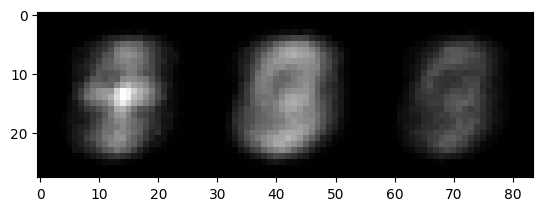

Generated Image 1


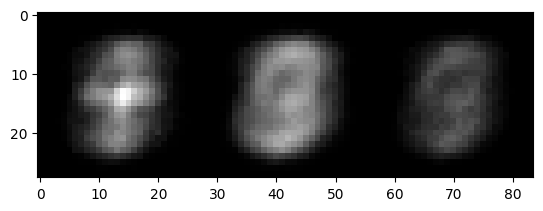

Generated Image 2


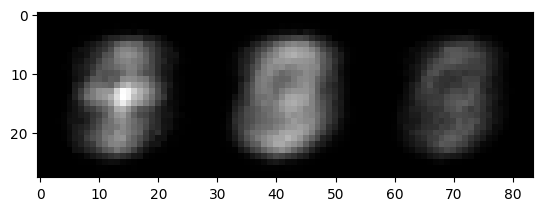

Generated Image 3


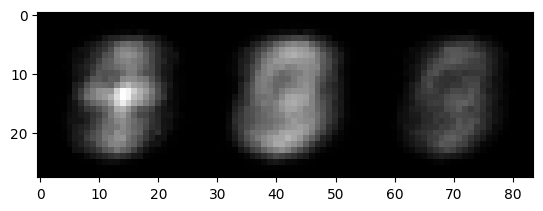

Generated Image 4


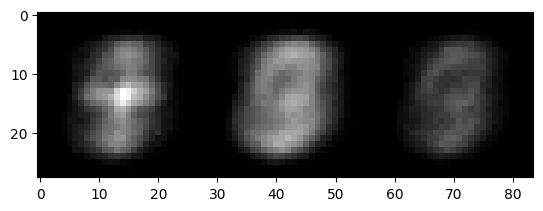

In [ ]:
#Shows the first 5 queries of the test dataset and the corresponding generated images
print(f"First 5 text queries: {X_text_test[0:5]}")
print(f"First 5 Answers: {y_text_test[0:5]}")

generated_images = text2image.predict(X_text_test_onehot[0:5])

for i in range(5):
  print(f"Generated Image {i}")
  plt.imshow(np.hstack(generated_images[i]), cmap='gray')
  plt.show()

In [ ]:
# More LSTM layers in the encoding seem to worsen image quality


---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

Note: I changed max_answer_length to 4 (given assignment code set it to 5, but largest answer length is 4, however: 99*99=9801 gives a maximum of 4). But then I get lower test accuracy than if max_answer_length = 5. Hence, max_answer_length = 5 is preferred. Maybe my thinking is flawed?

(10000,) (10000, 5, 28, 28) (10000,) (10000, 5, 28, 28)
Query #3157

X_text: "31*57" = y_text: "1767 "


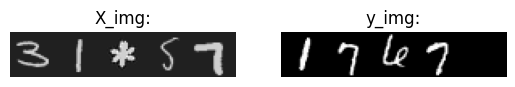

Query #9595

X_text: "95*95" = y_text: "9025 "


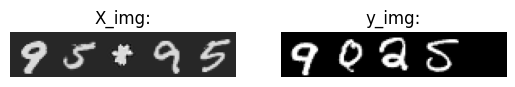

Query #6314

X_text: "63*14" = y_text: "882  "


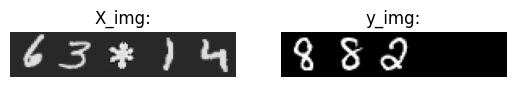

Query #3951

X_text: "39*51" = y_text: "1989 "


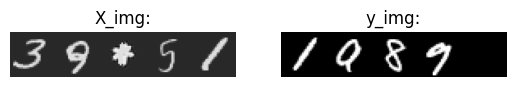

Query #9205

X_text: "92*5 " = y_text: "460  "


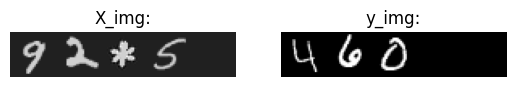

Query #9075

X_text: "90*75" = y_text: "6750 "


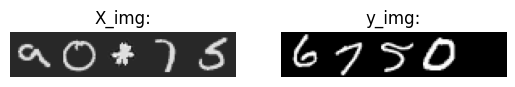

Query #6974

X_text: "69*74" = y_text: "5106 "


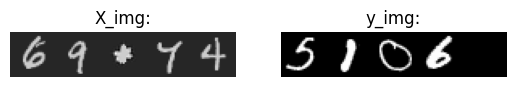

Query #8318

X_text: "83*18" = y_text: "1494 "


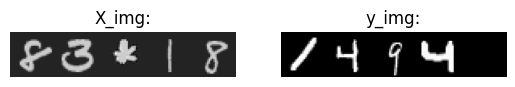

Query #4591

X_text: "45*91" = y_text: "4095 "


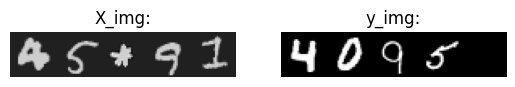

Query #5018

X_text: "50*18" = y_text: "900  "


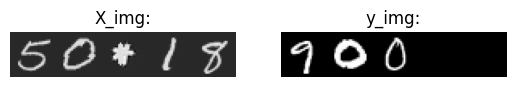

In [12]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789* '       # All unique characters that are used in the queries (12 in total: digits 0-9, 1 operand [*], and a space character ' '.)
highest_integer = 99                     # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22*10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is '99*99'='9801')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

In [13]:
X_text_train, X_text_test, X_img_train, X_img_test, y_text_train, y_text_test, y_img_train, y_img_test = train_test_split(
    X_text, X_img, y_text, y_img, test_size=0.05, random_state=42
)
X_text_train_onehot = encode_labels(X_text_train)
y_text_train_onehot = encode_labels(y_text_train)

X_text_test_onehot = encode_labels(X_text_test)
y_text_test_onehot = encode_labels(y_text_test)

In [ ]:
# First, text2text model

In [14]:
# Train the Model
model = build_text2text_model()
model.fit(X_text_train_onehot, y_text_train_onehot, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_text_test_onehot, y_text_test_onehot, verbose=0)

# Print or store the results
print(f"Test Accuracy: {test_accuracy}")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 256)               275456    
                                                                 
 repeat_vector_6 (RepeatVec  (None, 5, 256)            0         
 tor)                                                            
                                                                 
 lstm_13 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_6 (TimeDi  (None, 5, 12)             3084      
 stributed)                                                      
                                                                 
Total params: 803852 (3.07 MB)
Trainable params: 803852 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Test Accuracy: 0.7

In [ ]:
# Print or store the results
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions_onehot = model.predict(X_text_test_onehot)

# Convert one-hot encoded predictions and actual values to text
predictions_text = [decode_labels(pred) for pred in predictions_onehot]

# Find indices where predictions differ from actual values
incorrect_indices = np.where(predictions_text != y_text_test)[0]

# Display the queries and solutions for incorrectly predicted samples
for idx in incorrect_indices[0:15]:
    print("Query:")
    print(X_text_test[idx])
    print("Actual Solution:")
    print(y_text_test[idx])
    print("Predicted Solution:")
    print(predictions_text[idx])
    print("\n")

Test Accuracy: 0.7904000282287598
16/16 [==============================] - 1s 3ms/step
Query:
62*52
Actual Solution:
3224 
Predicted Solution:
3164 


Query:
46*84
Actual Solution:
3864 
Predicted Solution:
3604 


Query:
17*31
Actual Solution:
527  
Predicted Solution:
497  


Query:
47*42
Actual Solution:
1974 
Predicted Solution:
1994 


Query:
45*21
Actual Solution:
945  
Predicted Solution:
905  


Query:
5*76 
Actual Solution:
380  
Predicted Solution:
390  


Query:
63*63
Actual Solution:
3969 
Predicted Solution:
4509 


Query:
74*87
Actual Solution:
6438 
Predicted Solution:
6398 


Query:
52*72
Actual Solution:
3744 
Predicted Solution:
3644 


Query:
56*53
Actual Solution:
2968 
Predicted Solution:
3908 


Query:
39*99
Actual Solution:
3861 
Predicted Solution:
3881 


Query:
70*51
Actual Solution:
3570 
Predicted Solution:
3170 


Query:
81*58
Actual Solution:
4698 
Predicted Solution:
4508 


Query:
98*96
Actual Solution:
9408 
Predicted Solution:
9308 


Query:
22*49
Actu

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Sequential

# Train the Model
model = build_text2text_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
model.fit(
    X_text_train_onehot,
    y_text_train_onehot,
    epochs=20,
    batch_size=32,
    validation_split=0.05,  # Adjusted to use 95% of data for training and 5% for validation
    callbacks=[early_stopping, model_checkpoint],
    verbose=0
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_text_test_onehot, y_text_test_onehot, verbose=0)


# Print or store the results
print(f"Test Accuracy: {test_accuracy}")

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 256)               275456    
                                                                 
 repeat_vector_26 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_56 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_74 (TimeD  (None, 5, 12)             3084      
 istributed)                                                     
                                                                 
Total params: 803852 (3.07 MB)
Trainable params: 803852 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Test Accuracy: 0.

In [ ]:
# Second, image2text model

In [20]:
def build_image2text_model():
    image2text = Sequential()

    # Encoder (for image sequences)
    image2text.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 28, 28, 1)))
    image2text.add(TimeDistributed(Flatten()))
    image2text.add(LSTM(256))
    image2text.add(Dropout(0.8))

    # Repeat the output for max_answer_length times
    image2text.add(RepeatVector(max_answer_length))

    # Decoder (for generating text)
    image2text.add(LSTM(256, return_sequences=True))
    image2text.add(Dropout(0.8))
    image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Compile the model
    image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    image2text.summary()

    return image2text

# Build and train the image-to-text model
image2text_model = build_image2text_model()
image2text_model.fit(X_img_train, y_text_train_onehot, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss_img, test_accuracy_img = image2text_model.evaluate(X_img_test, y_text_test_onehot)
print(f'Image-to-Text Model Test Accuracy: {test_accuracy_img}')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeD  (None, None, 26, 26, 32   320       
 istributed)                 )                                   
                                                                 
 time_distributed_11 (TimeD  (None, None, 21632)       0         
 istributed)                                                     
                                                                 
 lstm_16 (LSTM)              (None, 256)               22414336  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector_8 (RepeatVec  (None, 5, 256)            0         
 tor)                                                            
                                                      

16/16 [==============================] - 1s 8ms/step
Generated Texts: ['2084 ', '4124 ', '707  ', '1004 ', '1075 ', '2120 ', '484  ', '184  ', '3073 ', '104  ', '1000 ', '4704 ', '3004 ', '2074 ', '3073 ']
Correct Answers: ['3224 ' '3864 ' '527  ' '1974 ' '945  ' '2520 ' '380  ' '104  ' '3969 '
 '156  ' '1350 ' '6438 ' '3744 ' '2968 ' '3861 ']
Query 0


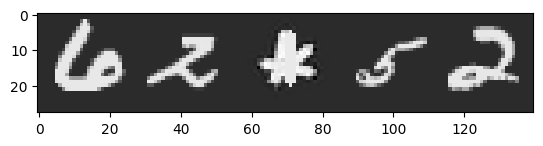

Query 1


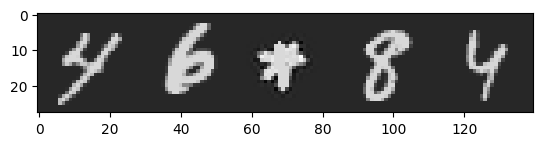

Query 2


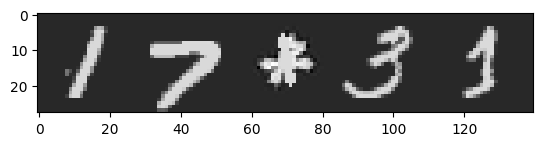

Query 3


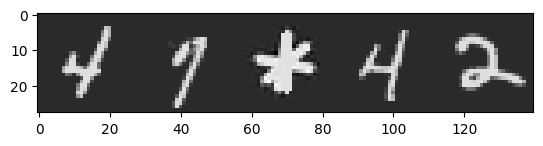

Query 4


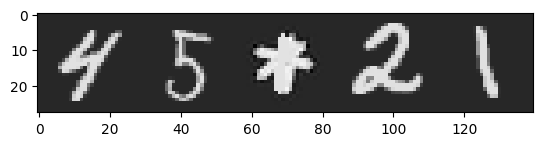

In [ ]:
generated_texts = image2text_model.predict(X_img_test)

decoded_texts = []

# Loop over the generated texts and decode each element
for text in generated_texts:
    decoded_text = decode_labels(text)
    decoded_texts.append(decoded_text)

# Print the first 15 decoded texts and the correct answers
print(f"Generated Texts: {decoded_texts[0:15]}")
print(f"Correct Answers: {y_text_test[0:15]}")
for i in range(5):
  print(f"Query {i}")
  plt.imshow(np.hstack(X_img_test[i]), cmap='gray')
  plt.show()

In [ ]:
def build_image2text_model(lstm_units, dropout_rate, conv_filters):
    image2text = Sequential()

    # Encoder (for image sequences)
    image2text.add(TimeDistributed(Conv2D(conv_filters, (7, 7), activation='relu'), input_shape=(None, 28, 28, 1)))
    image2text.add(TimeDistributed(Flatten()))
    image2text.add(LSTM(lstm_units))
    image2text.add(Dropout(dropout_rate))

    # Repeat the output for max_answer_length times
    image2text.add(RepeatVector(max_answer_length))

    # Decoder (for generating text)
    image2text.add(LSTM(lstm_units, return_sequences=True))
    image2text.add(Dropout(dropout_rate))
    image2text.add(TimeDistributed(Dense(128, activation='relu')))
    image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Compile the model
    image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return image2text

param_grid = {
    'lstm_units': [1024],
    'dropout_rate': [0.5],
    'conv_filters': [16]
}

results = []

for params in product(*param_grid.values()):
    lstm_units, dropout_rate, conv_filters = params
    print(f"Training model with LSTM units: {lstm_units}, Dropout rate: {dropout_rate}, Convolutional filters: {conv_filters}")

    # Assume encode_labels, X_img_train, y_text_train are defined
    y_text_train_onehot = encode_labels(y_text_train)
    y_text_test_onehot = encode_labels(y_text_test)

    # Build and train the image-to-text model
    image2text_model = build_image2text_model(lstm_units, dropout_rate, conv_filters)
    image2text_model.fit(X_img_train, y_text_train_onehot, epochs=20, batch_size=32, validation_split=0.05)

    # Evaluate the model
    test_loss_img, test_accuracy_img = image2text_model.evaluate(X_img_test, y_text_test_onehot)
    print(f'Image-to-Text Model Test Accuracy: {test_accuracy_img}%')

    results.append((lstm_units, dropout_rate, conv_filters, f"{test_accuracy_img:.2f}%"))

# Create and display a DataFrame from the results
results_df = pd.DataFrame(results, columns=['LSTM Units', 'Dropout Rate', 'Conv Filters', 'Test Accuracy'])
print("Results Overview:")
print(results_df.to_string(index=False))

Training model with LSTM units: 1024, Dropout rate: 0.5, Convolutional filters: 16
Epoch 1/20
283/283 [==============================] - 15s 41ms/step - loss: 1.7106 - accuracy: 0.3836 - val_loss: 1.5596 - val_accuracy: 0.4211
Epoch 2/20
283/283 [==============================] - 10s 37ms/step - loss: 1.4917 - accuracy: 0.4432 - val_loss: 1.3889 - val_accuracy: 0.4661
Epoch 3/20
283/283 [==============================] - 10s 37ms/step - loss: 1.3265 - accuracy: 0.4873 - val_loss: 1.2824 - val_accuracy: 0.4901
Epoch 4/20
283/283 [==============================] - 11s 37ms/step - loss: 1.2313 - accuracy: 0.5108 - val_loss: 1.2495 - val_accuracy: 0.5048
Epoch 5/20
283/283 [==============================] - 10s 36ms/step - loss: 1.1662 - accuracy: 0.5317 - val_loss: 1.2174 - val_accuracy: 0.5171
Epoch 6/20
283/283 [==============================] - 10s 36ms/step - loss: 1.1090 - accuracy: 0.5474 - val_loss: 1.2148 - val_accuracy: 0.5280
Epoch 7/20
283/283 [==============================] -